<a href="https://colab.research.google.com/github/MJMortensonWarwick/AnalyticsInPractice2425/blob/main/7_1_Troubleshooting_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Troubleshooting ML Models
This Notebook will go over some common issues in ML models and how they can be addressed. We'll start with a classic ...

## Over- and Under-fitting
To demonstrate, we'll work with the dataset from the last few weeks (week 5 in my.wbs):

In [1]:
from google.colab import files
uploaded = files.upload()

Saving credit_data_final.csv to credit_data_final.csv


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('credit_data_final.csv')

y_value = df['class'] # set the y
y_values = np.ravel(y_value) # change to an array (list)

x_values = df.drop('class', axis=1) # drop the y from the dataframe

# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=4567, stratify=y_value)

# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(800, 28)
(200, 28)
(800,)
(200,)


Now we will deliberately fit a terrible decision tree, setting their hyperparameters for minimum regularisation:

In [3]:
from sklearn.tree import DecisionTreeClassifier as tree
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# specift algo and fit to data
tree_algo = tree(min_samples_split=2, max_depth=None, min_samples_leaf=1, max_features=None)
tree_model = tree_algo.fit(X_train, Y_train)

# Predict the training data
predict = tree_model.predict(X_train)

# Calculate Accuracy
accuracy = accuracy_score(Y_train, predict)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict, average='macro')
print(f"Macro Precision: {precision}")
print(f"Macro Recall: {recall}")
print(f"Macro F1-score: {f1_score}")
print("\n")

Accuracy: 1.0
Macro Precision: 1.0
Macro Recall: 1.0
Macro F1-score: 1.0




Fantastic! Our model looks perfect :)

Or is it ...

In [4]:
# Predict the test data
predict = tree_model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(Y_test, predict)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')
print(f"Macro Precision: {precision}")
print(f"Macro Recall: {recall}")
print(f"Macro F1-score: {f1_score}")
print("\n")

Accuracy: 0.645
Macro Precision: 0.591824316849209
Macro Recall: 0.5988095238095238
Macro F1-score: 0.593809891587288




This is the classical indication of overfitting. Our training scores are perfect (or very good) but our testing scores are very poor.

But how about detecting the opposite? Let's respecify the algorithm:

In [5]:
from sklearn.tree import DecisionTreeClassifier as tree
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# specift algo and fit to data
tree_algo = tree(min_samples_split=10, max_depth=2, max_features='sqrt')
tree_model = tree_algo.fit(X_train, Y_train)

Now we have very strict regularisation (most notably _max\_depth=2_ ). Let's see how it performs on training:

In [6]:
# Predict the training data
predict = tree_model.predict(X_train)

# Calculate Accuracy
accuracy = accuracy_score(Y_train, predict)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict, average='macro')
print(f"Macro Precision: {precision}")
print(f"Macro Recall: {recall}")
print(f"Macro F1-score: {f1_score}")
print("\n")

Accuracy: 0.70375
Macro Precision: 0.6300325081270317
Macro Recall: 0.5967261904761905
Macro F1-score: 0.6016597510373445




Much lower metrics. This in itself is a good indicator of underfitting - that the numbers aren't great even on training data. However, this is problem specific, we don't necessarily know how good we can get (if we were ideally fitting). We can get another clue from the testing performance though:

In [7]:
# Predict the test data
predict = tree_model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(Y_test, predict)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')
print(f"Macro Precision: {precision}")
print(f"Macro Recall: {recall}")
print(f"Macro F1-score: {f1_score}")
print("\n")

Accuracy: 0.7
Macro Precision: 0.6265822784810127
Macro Recall: 0.6
Macro F1-score: 0.6052112120015791




Most metrics are very, very close in training and testing. This can indicate we have under-fitted.

Also telling can be the confusion matrix:

Decision Tree Confusion Matrix


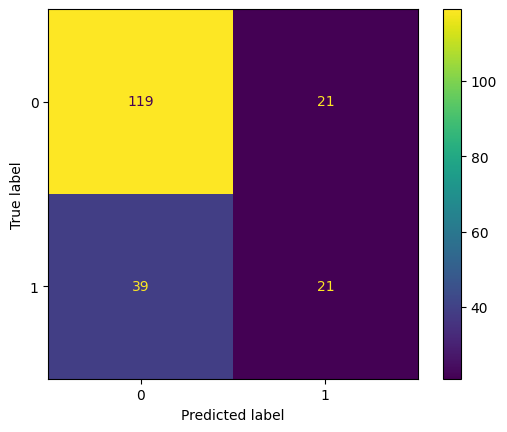

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay as CM

print("Decision Tree Confusion Matrix")
predict = tree_model.predict(X_test)
CM.from_predictions(Y_test, predict)

We can see here the tree slightly underpredicts class 1. There are 60 examples in test but we only predict 42. This is not a particularly extreme example, but indeed any time we see part of the problem underpredicted this can suggest we haven't learned enough 'rules' to correctly manage the problem.

## Class Imbalance
Another cause of both issues in the modeling and lower performance scores can be class imbalance. Often in the online tutorials you get perfectly balanced datasets. In many real-world domains though the opposite can be true. Consider examples like disease prediction, fraud detection or academic misconduct ... fortunately these are often relatively rare events and we would expect to find many more class 0's than class 1's.

Let's replicate this with some fake data:

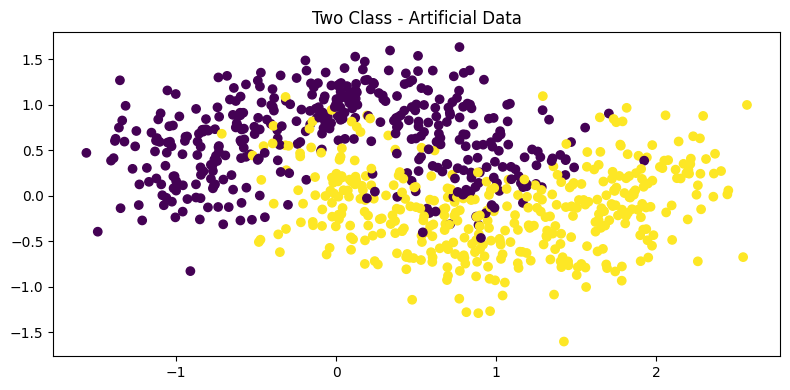

In [9]:
# adapted from https://scikit-learn.org/dev/datasets/sample_generators.html#sample-generators
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# create a plot of the data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# create the data
X, Y = make_moons(n_samples=800, noise=0.3, random_state=123)

# plot the artificial data
ax.scatter(X[:, 0], X[:, 1], c=Y)
ax.set_title("Two Class - Artificial Data")

plt.tight_layout()
plt.show()

We can also have a look at the data using pandas:

In [10]:
moons_data = pd.DataFrame(X)
moons_data['class'] = Y
moons_data.head()

,0,1,class
0,0.692236,0.811689,0
1,1.204024,-0.331594,1
2,-0.486883,0.857528,0
3,-0.397174,1.172754,0
4,0.052909,1.403577,0


Now we are going to remove some of the class 1's to make the data imbalanced:

In [11]:
moon_zeros = moons_data[moons_data['class'] == 0]
moon_ones = moons_data[moons_data['class'] == 1]

# combine all the zeros and just 10 examples of class = 1
new_moons_data = pd.concat([moon_zeros, moon_ones.sample(n=10)])
new_moons_data.head()

,0,1,class
0,0.692236,0.811689,0
2,-0.486883,0.857528,0
3,-0.397174,1.172754,0
4,0.052909,1.403577,0
5,0.180865,1.269539,0


In [12]:
# print how many of each class we have
new_moons_data['class'].value_counts()

,count
class,
0,400
1,10


Let's fit a basic decision tree and check for performance:

In [13]:
# seperate x and y
y_value = np.ravel(new_moons_data['class'])
x_values = new_moons_data.drop('class', axis=1)

# split data into training and test
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=4567, stratify=y_value)

# decision tree - standard hyperparameters
tree_algo = tree()
tree_model = tree_algo.fit(X_train, Y_train)

# Predict the test data
predict = tree_model.predict(X_test)

# Check accuracy on test data
accuracy = accuracy_score(Y_test, predict)
print(f"Accuracy: {accuracy}")

Accuracy: 0.975609756097561


So far, so good. 98% accuracy seems like a good model ... but is it?

Decision Tree Confusion Matrix


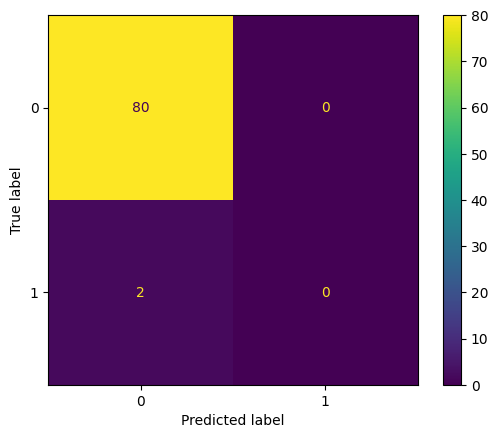

In [14]:
print("Decision Tree Confusion Matrix")
CM.from_predictions(Y_test, predict)

While it looks like a good model from just accuracy, we can see that it never predicts class 1 at all I.e. its overall accuracy is 98%, its accuracy on just class 0 is 100%, but its accuracy on just class 1 is 0%.

We can see full performance on class one using this code:



In [15]:
# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average=None)

# because each metric is now a list including class 0 and 1 we can specify
# list item 0 ([0]) for class 0 and item 1 ([1]) for the other
print(f"Class 0 Precision: {precision[0]}")
print(f"Class 0 Recall: {recall[0]}")
print(f"Class 0 F1-score: {f1_score[0]}")
print("\n")
print(f"Class 1 Precision: {precision[1]}")
print(f"Class 1 Recall: {recall[1]}")
print(f"Class 1 F1-score: {f1_score[1]}")

Class 0 Precision: 0.975609756097561
Class 0 Recall: 1.0
Class 0 F1-score: 0.9876543209876543


Class 1 Precision: 0.0
Class 1 Recall: 0.0
Class 1 F1-score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Now in many cases (discussed above) its this minority class that we really care about. Irrespective of the overall accuracy of 98%, or the performance in class 0, this 0% on class 1 may be a big problem. So how can we deal with it? (We will assume we have decided that recall is our main metric).

### OPTION ONE: Hyperparameter tune based on just minority class performance
Here we can try tuning the algorithm based on performance on just class 1. Instead of using a "macro recall" metric we can have it use "recall" on just class 1:

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# this is the list of parameters we will tune. Some are fixed values some are distributions
tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 9),  # Draw from a uniform distribution between 3 and 15
    'min_samples_split': randint(3, 9),  # Draw from a uniform distribution between 2 and 10
    'max_features': ['sqrt', 'log2', None]
}

# we will specify recall based on class 1
score = 'recall' # defaults to class 1

print(f"Tuning hyperparameters for {score}")
print("\n")

# do the search using 5 folds/chunks
clf = RandomizedSearchCV(tree(), tuned_parameters, cv=5, random_state=1984,
                         scoring= score, n_iter=20, refit=True)

# pass the data to fit/train
clf.fit(X_train, Y_train)

# create the model
tree_algo = tree(**clf.best_params_)
tree_model = tree_algo.fit(X_train, Y_train)

# Predict the test data
predict = tree_model.predict(X_test)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average=None)

# because each metric is now a list including class 0 and 1 we can specify
# list item 0 ([0]) for class 0 and item 1 ([1]) for the other
print(f"Class 0 Precision: {precision[0]}")
print(f"Class 0 Recall: {recall[0]}")
print(f"Class 0 F1-score: {f1_score[0]}")
print("\n")
print(f"Class 1 Precision: {precision[1]}")
print(f"Class 1 Recall: {recall[1]}")
print(f"Class 1 F1-score: {f1_score[1]}")

Tuning hyperparameters for recall


Class 0 Precision: 0.975
Class 0 Recall: 0.975
Class 0 F1-score: 0.975


Class 1 Precision: 0.0
Class 1 Recall: 0.0
Class 1 F1-score: 0.0


Class 1 recall is still 0%. Let's see the confusion matrix to confirm:

Decision Tree Confusion Matrix


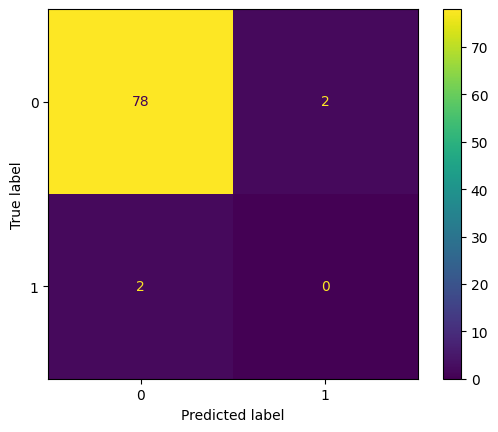

In [17]:
print("Decision Tree Confusion Matrix")
CM.from_predictions(Y_test, predict)

While recall is still bad, we can see at least the model has tried to predict class 1.

Let's look at another method:

# OPTION TWO: Biasing the decision threshold
As we spoke about earlier in the module, the decision threshold on binary classification is standardly 0.5. That means our model only predicts class 1 if we have a probability of class 1 that is 50% or higher.

However, if we know our model may struggle to predict class 1, or be reluctant to focus on this, why not make that threshold lower? Let's run again with the threshold automatically adjusted to the levels of class imbalance:

Class 0 Precision: 0.9871794871794872
Class 0 Recall: 0.9625
Class 0 F1-score: 0.9746835443037974


Class 1 Precision: 0.25
Class 1 Recall: 0.5
Class 1 F1-score: 0.3333333333333333


Decision Tree Confusion Matrix


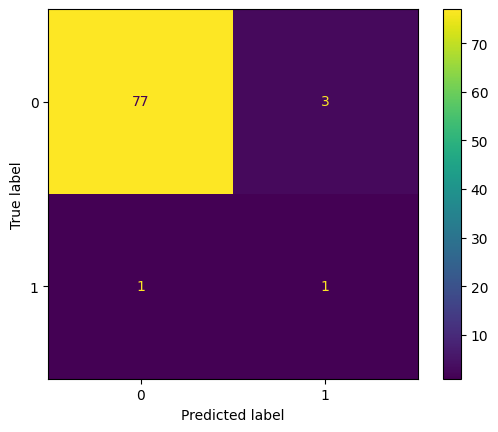

In [18]:
# decision tree - previous hyperparameters from random search plus adjusted threshold
tree_algo = tree(**clf.best_params_, class_weight='balanced')
tree_model = tree_algo.fit(X_train, Y_train)

# Predict the test data
predict = tree_model.predict(X_test)

# Predict the test data
predict = tree_model.predict(X_test)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average=None)

# because each metric is now a list including class 0 and 1 we can specify
# list item 0 ([0]) for class 0 and item 1 ([1]) for the other
print(f"Class 0 Precision: {precision[0]}")
print(f"Class 0 Recall: {recall[0]}")
print(f"Class 0 F1-score: {f1_score[0]}")
print("\n")
print(f"Class 1 Precision: {precision[1]}")
print(f"Class 1 Recall: {recall[1]}")
print(f"Class 1 F1-score: {f1_score[1]}")
print("\n")

# Confusion matrix
print("Decision Tree Confusion Matrix")
CM.from_predictions(Y_test, predict)

Class 1 recall is still only 50%, but obviously 50% > 0%! However, we can see we achieved what we wanted which was to force the model to predict more class 1's. In the model without threshold adjustment (but also hyperparameter optimised for class 1 recall) we predicted 2x class 1's (0 in the original model). This time we have predicted 4x so double!

Let's look at another option ...

### Undersampling
If we know that we have many class 0's and less class 1's, we can undersample class 0 ... that basically means not using all the data:

In [19]:
from imblearn.under_sampling import RandomUnderSampler

# create an undersampler that will return 4x as many majority as minority class
# I.e. sampling_strategy=0.25 means minority class will be 25% of the majority class
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.25)

# Note we only undersample the training data not the test data
X_train, Y_train = rus.fit_resample(X_train, Y_train)

# get the value countes by temporarily converting to a dataframe
pd.Series(Y_train).value_counts()

,count
0,32
1,8


It works (32x class 0 and still 8x class 1), but not really enough training data in this case. Let's fit the model anyway for fun:

Class 0 Precision: 1.0
Class 0 Recall: 0.9
Class 0 F1-score: 0.9473684210526315


Class 1 Precision: 0.2
Class 1 Recall: 1.0
Class 1 F1-score: 0.3333333333333333


Decision Tree Confusion Matrix


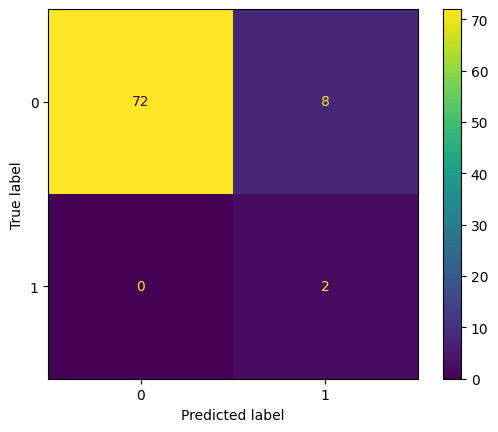

In [20]:
# decision tree - standard hyperparameters
tree_algo = tree()
tree_model = tree_algo.fit(X_train, Y_train)

# Predict the test data
predict = tree_model.predict(X_test)

# Predict the test data
predict = tree_model.predict(X_test)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average=None)

# because each metric is now a list including class 0 and 1 we can specify
# list item 0 ([0]) for class 0 and item 1 ([1]) for the other
print(f"Class 0 Precision: {precision[0]}")
print(f"Class 0 Recall: {recall[0]}")
print(f"Class 0 F1-score: {f1_score[0]}")
print("\n")
print(f"Class 1 Precision: {precision[1]}")
print(f"Class 1 Recall: {recall[1]}")
print(f"Class 1 F1-score: {f1_score[1]}")
print("\n")

# Confusion matrix
print("Decision Tree Confusion Matrix")
CM.from_predictions(Y_test, predict)

Again the model is definitely better at predicting class 1 than the first model - in fact 100% class 1 recall. However, we make our precision worse. This is quite common in these problems, improving one metric will damage another.

If undersampling won't work because we don't have enough examples of 1, how about the other way?

### Oversampling
Here we will use the SMOTE method to generate synthetic samples of class 1:

In [21]:
# RESET THE DATA TO REMOVE THE EFFECT OF UNDERSAMPLING

# seperate x and y
y_value = np.ravel(new_moons_data['class'])
x_values = new_moons_data.drop('class', axis=1)

# split data into training and test
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=4567, stratify=y_value)

In [22]:
from imblearn.over_sampling import SMOTE

# create an SMOTE instance that will return 4x as many majority as minority class
# I.e. sampling_strategy=0.25 means minority class will be 25% of the majority class
smote = SMOTE(random_state=42, sampling_strategy=0.25)

# Note we only undersample the training data not the test data
X_train, Y_train = smote.fit_resample(X_train, Y_train)

# get the value countes by temporarily converting to a dataframe
pd.Series(Y_train).value_counts()

,count
0,320
1,80


Again, everything has worked - we now have 80 training examples of class 1 rather than 8. But does it help?

Class 0 Precision: 0.9873417721518988
Class 0 Recall: 0.975
Class 0 F1-score: 0.9811320754716981


Class 1 Precision: 0.3333333333333333
Class 1 Recall: 0.5
Class 1 F1-score: 0.4


Decision Tree Confusion Matrix


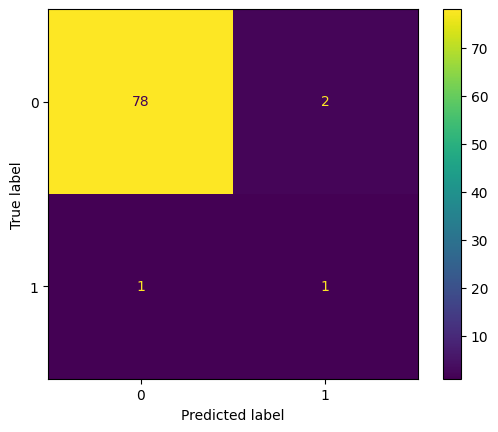

In [23]:
# decision tree - standard hyperparameters
tree_algo = tree()
tree_model = tree_algo.fit(X_train, Y_train)

# Predict the test data
predict = tree_model.predict(X_test)

# Predict the test data
predict = tree_model.predict(X_test)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average=None)

# because each metric is now a list including class 0 and 1 we can specify
# list item 0 ([0]) for class 0 and item 1 ([1]) for the other
print(f"Class 0 Precision: {precision[0]}")
print(f"Class 0 Recall: {recall[0]}")
print(f"Class 0 F1-score: {f1_score[0]}")
print("\n")
print(f"Class 1 Precision: {precision[1]}")
print(f"Class 1 Recall: {recall[1]}")
print(f"Class 1 F1-score: {f1_score[1]}")
print("\n")

# Confusion matrix
print("Decision Tree Confusion Matrix")
CM.from_predictions(Y_test, predict)

Slightly more inclined to predict class 1 than the original, but probably not the best model we have seen. In practice, we oversampled too hard (we now have 8 real examples of class 1 and 72 synthetic ones).

So what is the best model? We would need to experiment and find out! Maybe some combination of the above four would give us better overall performance.

# Multi-class Classification
We will end by just demoing a model fit for a multiclass case. We should note the code is basically the same throughout.

In [24]:
from sklearn.datasets import make_classification

# generate artificial data for 5 class classification
X, Y = make_classification(n_samples=500, n_classes=5, n_informative=4, random_state=123)

fake_data = pd.DataFrame(X)
fake_data['class'] = Y
fake_data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,class
0,1.014592,-0.177833,1.212151,-1.429679,-0.844274,1.740312,0.836186,-1.736907,1.677634,-0.347955,...,-0.055537,-0.319690,1.783051,-1.620938,-0.742080,-2.156547,0.297082,0.675748,-0.019105,3
1,1.674879,-1.386293,0.759391,-1.481794,0.275494,2.052528,-1.164747,1.557078,0.137584,-1.853022,...,0.788579,0.611384,1.624125,-0.943281,-0.139477,1.130020,0.597144,0.441203,1.030201,3
2,0.287461,1.932166,-1.188135,1.073414,0.671983,-0.810445,-0.530596,-1.755540,2.034083,1.066881,...,-0.827758,-0.291577,0.982315,1.397589,-0.900553,2.195351,2.090406,0.577108,0.436545,0
3,0.514904,-1.827781,-1.154551,-0.964384,-0.579608,0.446449,0.662499,0.503596,0.387970,2.417113,...,-0.617200,0.117624,0.736260,-1.907156,0.810031,-0.077824,-1.170199,0.419940,0.362539,4
4,0.923203,-1.298601,0.234343,-0.137969,0.727587,1.790539,-1.131213,1.903589,1.234253,-1.646777,...,-1.146304,-0.778873,0.481869,1.392814,-0.893920,1.148936,0.643505,-0.205255,-1.039693,0


We have a 5-class dataset with 20x predictors. We can split as normal and fit a logistic regression.

Note: logistic regression is strictly binary so we are making all the _one\_versus\_one_ models to find the final model.

Accuracy: 0.5
Macro Precision: 0.5034035087719299
Macro Recall: 0.5
Macro F1-score: 0.4945804195804196


Logistic Regression Confusion Matrix


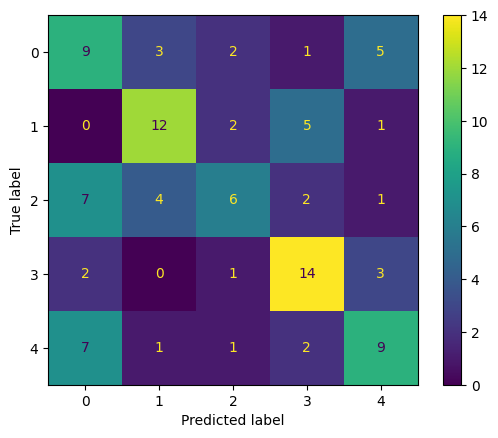

In [25]:
from sklearn.linear_model import LogisticRegression as LR

y_value = np.ravel(fake_data['class'])
x_values = fake_data.drop('class', axis=1)

# split data into training and test
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=4567, stratify=y_value)

# specify algo and train model
LogR_algo = LR()
LogR_model = LogR_algo.fit(X_train, Y_train)

# predict
predict = LogR_model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(Y_test, predict)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')
print(f"Macro Precision: {precision}")
print(f"Macro Recall: {recall}")
print(f"Macro F1-score: {f1_score}")
print("\n")

# Confusion matrix
print("Logistic Regression Confusion Matrix")
CM.from_predictions(Y_test, predict)

Accuracy at 50% would be a bad score for a binary problem with even class sizes (which we have) ... it would be performing as well as a random guess.

However, for the random unbiased classifier in an even 5 class problem we expect to score:
<br>
$ 5 \cdot (0.2 \cdot 0.2) = 0.2$
<br>
So our performance is acutally 50% versus 20%. Is that good enough? ...
<br><br>
...
<br><br>
...
<br><br>
__IT DEPENDS!__
<br>

For completeness, we can also see what would happen with _one\_versus\_all_ (now depreciated from the main library)

Accuracy: 0.49
Macro Precision: 0.4810606060606061
Macro Recall: 0.49000000000000005
Macro F1-score: 0.4788818637502848


Logistic Regression Confusion Matrix


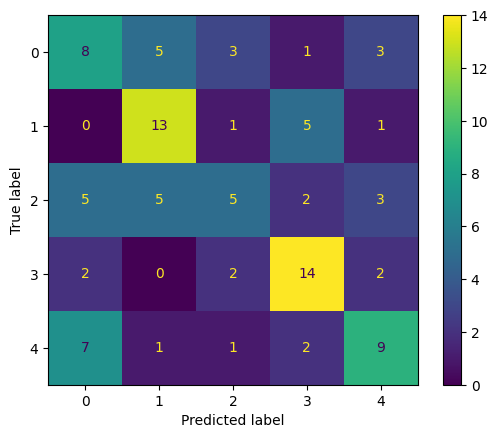

In [26]:
from sklearn.multiclass import OneVsRestClassifier as OVR

# specify algo and train model
LogR_algo = OVR(LR())
LogR_model = LogR_algo.fit(X_train, Y_train)

# predict
predict = LogR_model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(Y_test, predict)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')
print(f"Macro Precision: {precision}")
print(f"Macro Recall: {recall}")
print(f"Macro F1-score: {f1_score}")
print("\n")

# Confusion matrix
print("Logistic Regression Confusion Matrix")
CM.from_predictions(Y_test, predict)

Slightly worse but not much difference.